In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.stats import weibull_min, multivariate_normal

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Life expectancy in ancient Egypt

In this notebook we want to investigate life lengths in ancient Egypt by using data of $141$ individuals. Let's start with reading in the data, a simple one column table with the first $82$ entries corresponding to men, and the remaining $59$ corresponding to women life lengths.

In [15]:
egypt = pd.read_csv(
    "data/egypt_data",
    skiprows=4,
    squeeze=True,
)
men = egypt[:82]
women = egypt[82:]

## Maximum likelihood estimation using Weibull

The Weibull distribution is often used in **survival analysis**, a branch of statistics analyzing the expected duration until a specific event occurs, e.g. death. Its density function is given by

$$
f(y) = b a^{-b} y^{b-1} e^{-(y \,/\, a)^b} 
$$

where $a, b > 0$ are shape parameters. Thus, given data $y_1, \ldots, y_n$, it is easy to verify that the log-likelihood function is

$$
l(a, b) = \sum_{i=1}^n - (y_i \,/\, a)^b + \log b + (b-1) \log y - b \log a.
$$

What follows is the maximum likelihood estimation for men and women respectively.

In [16]:
def log_lik(params, sex):
    a, b = params
    if sex == "men":
        y = men
    elif sex == "women":
        y = women
    return -np.sum(-(y / a) ** b + np.log(b) + (b - 1) * np.log(y) - b * np.log(a))

In [17]:
res_men = minimize(log_lik, np.array([30, 1]), args="men")
a_men, b_men = res_men.x

res_women = minimize(log_lik, np.array([30, 1]), args="women")
a_women, b_women = res_women.x

results = {
    "men": res_men,
    "women": res_women,
}

In [18]:
def plot_distribution(dist, label, color):
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    plt.plot(x, dist.pdf(x), color, label=label)
    plt.hist(dist.rvs(size=10**4), bins=10**2, density=True, color=color, alpha=.4)

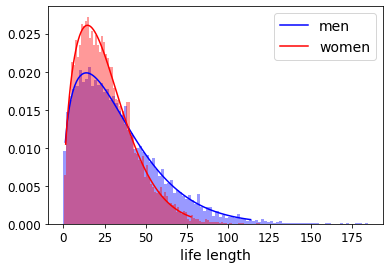

In [20]:
plot_distribution(weibull_min(b_men, scale=a_men), "men", "b")
plot_distribution(weibull_min(b_women, scale=a_women), "women", "r")
plt.xlabel("life length")
plt.legend();

## Lazy Bayesian - What's $\mathbb{P}(y > 40)$?

For further analyses, we will use a less Bayesian method, as it is well known, works well and is practical. Basically, with the programming we have done so far, we have all the ingredients ready. We utilize the normal approximation

$$
N_2(p_{ML},\, \Sigma_{ML})
$$

with $p_{ML} = (a_{ML}, \, b_{ML})^\top$ and the observed Fisher information matrix

$$
\Sigma_{ML} = \left(\frac{\partial^2}{\partial^2 p^2} l(a_{ML},\,b_{ML})\right)^{-1}.
$$

This way samples can be created without any problems, and we would now like to address the question of how great the probability is of living longer than 40 years in ancient Egypt.

**Note:** The cumulative density function is given by $F(y) = 1 - e^{-(y \,/\, a)^b}$.

In [25]:
y0 = 40
sim = 10**4

medians=[]
for name, res in results.items():
    print(f"---- {name.capitalize()} ----")
    theta = multivariate_normal.rvs(
        mean=res.x,
        cov=res.hess_inv,
        size=sim,
    )

    a, b = theta.T
    prob = np.exp( -(y0 / a) ** b)
    quantiles = np.round(np.quantile(prob, [0.05,0.50,0.95]), 4)
    print(f"Prob('y > {y0}'): {quantiles} ({name})")

    med = a * np.log(2) ** (b ** -1)
    medians.append(med)
    quantiles = np.round(np.quantile(med, [0.05,0.50,0.95]), 4)
    print(f"Median life span: {quantiles} ({name})")

---- Men ----
Prob('y > 40'): [0.2535 0.3299 0.4006] (men)
Median life span: [23.4619 28.2502 33.0403] (men)
---- Women ----
Prob('y > 40'): [0.1296 0.1911 0.2526] (women)
Median life span: [19.3993 22.6968 26.0422] (women)


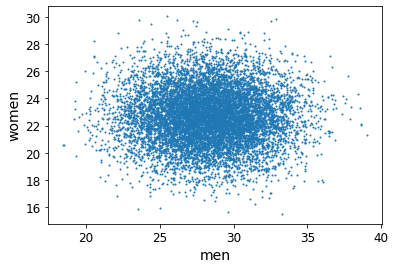

In [26]:
plt.scatter(medians[0], medians[1], s=1)
plt.xlabel("men")
plt.ylabel("women");

In order to visualize the difference between men and women lifespans more properly let 

$$
\delta = \text{median}(men) - \text{median}(women).
$$

Median delta life span : [-0.2628  5.5826 11.3793] (difference: men - women)


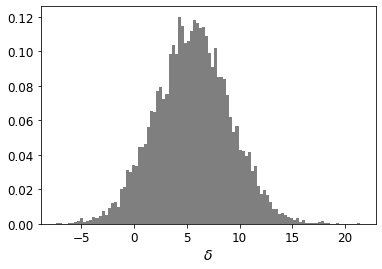

In [10]:
delta_med = medians[0] - medians[1]
quantiles = np.round(np.quantile(delta_med, [0.05,0.50,0.95]), 4)
print(f"Median delta life span : {quantiles} (difference: men - women)")

plt.hist(delta_med, bins=100, density=True, alpha=.5, color="k")
plt.xlabel(r"$\delta$");

## Survival curves

Survival curves give the probability that an individual (or any object of interest) will survive past a certain time $t > 0$. It is therefore given by

$$
S(t) = \mathbb{P} (y > t) = 1 - F(t)
$$

where $F$ is the cummulative distribution function. Thus under Weibull conditions with parameters $a, b > 0$

$$
S(t) = e^{-(y \,/\, a)^b}.
$$

We compare this parametric version with the non-parametric obtained by the relative proportion of individuals surpass each specific age.

In [27]:
ys = np.linspace(0, 100, 10**3)

In [28]:
# Parametric.
survival_men = np.exp( -(ys / a_men) ** b_men)
survival_women = np.exp( -(ys / a_women) ** b_women)

In [33]:
# Nonparametric.
survival_hat_men = np.array([men >= y for y in ys]).mean(axis=1)
survival_hat_women = np.array([women >= y for y in ys]).mean(axis=1)

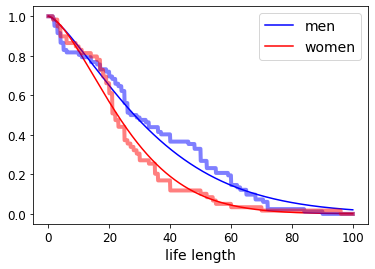

In [34]:
plt.plot(ys, survival_men, "b", label="men")
plt.plot(ys, survival_women, "r", label="women")
plt.plot(ys, survival_hat_men, "b", alpha=.5, lw=4.)
plt.plot(ys, survival_hat_women, "r", alpha=.5, lw=4.)
plt.xlabel("life length")
plt.legend();

In this figure it can be seen very clearly that women had a significantly lower life expectancy than men.